* Radif Ramadan

* Data Science / JCSDOL-014

* Modul 3 - Day 43

---
---

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, TargetEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [133]:
df = pd.read_csv('Employee.csv')
df.head(5)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


### **Target : `LeaveOrNot`**

In [135]:
x = df.drop(columns = 'LeaveOrNot')
y = df['LeaveOrNot']

### **Lakukan Feature Selection**

* Sebelum dilakukan feature selection, dilakukan uji korelasi baik data numeric ataupun kategori terhadap variabel target (LeaveOrNot)

In [136]:
from dython.nominal import associations, cramers_v
import matplotlib.pyplot as plt
import seaborn as sns

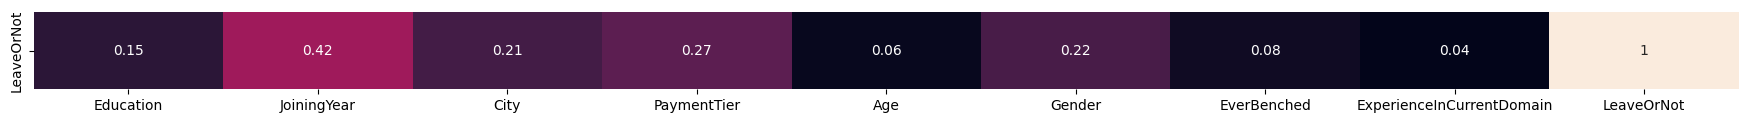

In [137]:
assoc_cr = []
col =  df.columns.tolist()
for i in col: 
    assoc = round(cramers_v(df['LeaveOrNot'], df[i]), 2) 
    assoc_cr.append(assoc)
    
df_cr = pd.DataFrame(data = [assoc_cr], columns = col, index=['LeaveOrNot'])

plt.figure(figsize=(22, 1))
sns.heatmap(df_cr, annot = True, cbar=False)
plt.show()

* Fitur-fitur yang memiliki korelasi rendah-sedang (0.1-0.5) akan digunakan sebagai fitur untuk modelling disertakan Domain Knowledgenya, diantaranya:

`Education` --> Latar pendidikan memiliki hubungan positif yang cukup kecil dengan retensi karyawan. Hal ini karena Karyawan dengan pendidikan tinggi mungkin lebih cenderung mencari peluang lebih baik di tempat lain

`JoiningYear` --> Tahun bergabung ke Company juga memiliki hubungan positif yang cukup signifikan dengan retensi karyawan. Semakin baru bergabung, semakin juga cenderung karyawan keluar dari perusahaan. Hal ini karena Karyawan yang telah bekerja lebih lama mungkin memiliki loyalitas lebih tinggi dan Karyawan yang baru bergabung lebih mungkin untuk keluar dari perusahaan (mencari passion dll)

`City` --> Hubungan antara kota dimana karyawan ditempatkan dengan retensi karyawan cukup tinggi. Hal ini dikarenakan lokasi tempat bekerja karyawan dapat berpengaruh terhadap keputusan karyawan untuk tetap bertahan atau tidak di perusaahan, misalnya seperti faktor aksesibilitas, biaya hidup, serta lingkungan kerja yang mendukung atau tidak.

`PaymentTier` --> Tingkat gaji karyawan memiliki pengaruh terhadap keputusan karyawan bertahan atau tidak di perusahaan. Tingkat gaji yang lebih tinggi dapat meningkatkan kepuasan kerja dan mengurangi kemungkinan karyawan keluar sedangkan Karyawan dengan gaji rendah mungkin mencari pekerjaan yang lebih menguntungkan.

`Gender` --> Gender memiliki hubungan yang cukup tinggi dengan retensi karyawan. Meskipun faktor gender tidak secara langsung menentukan apakah seseorang akan keluar atau bertahan, wanita cenderung mungkin mencari peluang di tempat lain yang dapat mempertimbangkan fleksibilitas kerja, keseimbangan antara kehidupan kerja dan keluarga atau memang memutuskan menjadi ibu rumah tangga saja setelah menikah

In [138]:
x_selection= df[['City', 'Gender', 'Education', 'PaymentTier', 'JoiningYear']]
y = df['LeaveOrNot']

### **Lakukan Feature Engineering**

In [139]:
ordinal_mapping = [{'col':'Education', 'mapping':{'Bachelors':1, 'Masters':2, 'PhD':3}}]

pipe_ordinal_scale = Pipeline([
    ('ordinal', OrdinalEncoder(cols=['Education',], mapping=ordinal_mapping))])


preprocessor = ColumnTransformer(
    transformers = [
        ('num', RobustScaler(), x_selection.select_dtypes(include = 'int64').columns),
        ('binary_encoder', BinaryEncoder(), ['Gender','City']),
        ('pipe_ordinal_scale', pipe_ordinal_scale, ['Education'])
    ])

x_processed = preprocessor.fit_transform(x_selection)

x_processed = pd.DataFrame(x_processed, 
                           columns = preprocessor.get_feature_names_out())

In [140]:
display(x_processed)

,num__PaymentTier,num__JoiningYear,binary_encoder__Gender_0,binary_encoder__Gender_1,binary_encoder__City_0,binary_encoder__City_1,pipe_ordinal_scale__Education
0,0.0,0.50,0.0,1.0,0.0,1.0,1.0
1,-2.0,-0.50,1.0,0.0,1.0,0.0,1.0
2,0.0,-0.25,1.0,0.0,1.0,1.0,1.0
3,0.0,0.25,0.0,1.0,0.0,1.0,2.0
4,0.0,0.50,0.0,1.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...
4648,0.0,-0.50,1.0,0.0,0.0,1.0,1.0
4649,-1.0,-0.50,0.0,1.0,1.0,0.0,2.0
4650,0.0,0.75,0.0,1.0,1.0,1.0,2.0
4651,0.0,-0.75,0.0,1.0,0.0,1.0,1.0


### **Split data menjadi Train 80% dan Test 20%**

In [141]:
X_train, X_test, y_train, y_test = train_test_split(x_processed, y, train_size = 0.8, random_state = 18)

### **Lakukan Modelling menggunakan Logistic Regression**

In [142]:
model = LogisticRegression(random_state = 25)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [143]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

Accuracy: 0.7379162191192267
Confusion Matrix:
 [[558  42]
 [202 129]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.93      0.82       600
           1       0.75      0.39      0.51       331

    accuracy                           0.74       931
   macro avg       0.74      0.66      0.67       931
weighted avg       0.74      0.74      0.71       931



### **Cek Multicollinearity**

In [144]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = x_processed.columns
vif_data["VIF"] = [variance_inflation_factor(x_processed, i) for i in range(x_processed.shape[1])]

vif_data

,Feature,VIF
0,num__PaymentTier,1.162052
1,num__JoiningYear,1.039048
2,binary_encoder__Gender_0,6.223284
3,binary_encoder__Gender_1,7.663882
4,binary_encoder__City_0,1.698518
5,binary_encoder__City_1,1.567782
6,pipe_ordinal_scale__Education,1.060528


### **Buat Interpretasi Hasil Summary**

* `Fitur dengan VIF < 5 `→ Aman, tidak ada multikolinearitas yang signifikan.
* `Fitur dengan 5 ≤ VIF < 10 `→ Indikasi multikolinearitas sedang (perlu dipertimbangkan untuk perbaikan).
* `Fitur dengan VIF ≥ 10 `→ Multikolinearitas tinggi (harus segera diperbaiki).

Didapati: 

`binary_encoder__Gender_0` --> Ada indikasi multikolinearitas sedang.

`binary_encoder__Gender_1` --> Ada indikasi multikolinearitas sedang.

Memungkinan ada hubungan linier yang kuat antar kedua fitur **akibat redundansi antar variabel Gender**

### **Tentukan Features mana yg paling penting**

In [145]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': abs(coefficients)
})

feature_importance = feature_importance.sort_values(by = 'Coefficient', 
                                                    ascending = False).reset_index(drop = True)

display(feature_importance)

,Feature,Coefficient
0,binary_encoder__City_1,1.104157
1,num__JoiningYear,0.875483
2,binary_encoder__Gender_1,0.559863
3,pipe_ordinal_scale__Education,0.419090
4,binary_encoder__Gender_0,0.387388
5,binary_encoder__City_0,0.325541
6,num__PaymentTier,0.313244


In [146]:
best_feature, best_val = feature_importance.iloc[0].values

print(f'Berdasarkan koefiesien nya fitur yang paling penting adalah fitur "{best_feature}" dengan nilai koefisien absolut {best_val.round(3)}')

Berdasarkan koefiesien nya fitur yang paling penting adalah fitur "binary_encoder__City_1" dengan nilai koefisien absolut 1.104
